In [31]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [33]:
#DESARROLLO UTILIZANDO METRICA FM

In [35]:
def metrica_fm(image: np.ndarray) -> float:
    
    M, N = image.shape
    F = np.fft.fft2(image)
    Fc = np.fft.fftshift(F)
    AF = np.abs(Fc)
    max_AF = np.max(AF)
    threshold = max_AF / 1000
    T_H = np.sum(AF > threshold)
    FM = T_H / (M * N)
    return FM

In [37]:
def roi_central(image: np.ndarray, porcentaje_roi: float = 0.1) -> np.ndarray: #Tomo ROI de 10%
    
    h, w = image.shape
    roi_h = int(np.sqrt(porcentaje_roi) * h)
    roi_w = int(np.sqrt(porcentaje_roi) * w)
    start_y = h // 2 - roi_h // 2
    start_x = w // 2 - roi_w // 2
    return image[start_y:start_y+roi_h, start_x:start_x+roi_w]

In [39]:
video_path = "focus_video.mov"  # Cargado del video

cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    raise IOError("No se pudo abrir el video")

In [41]:
fm_full_list = []
fm_roi_list = []
indice_cuadro_list = []

In [43]:
frame_id = 0
while True:
    ret, frame = cap.read()
    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    fm_full = metrica_fm(gray)
    roi = roi_central(gray, porcentaje_roi=0.1)
    fm_roi = metrica_fm(roi)

    fm_full_list.append(fm_full)
    fm_roi_list.append(fm_roi)
    indice_cuadro_list.append(frame_id)

    frame_id += 1

cap.release()

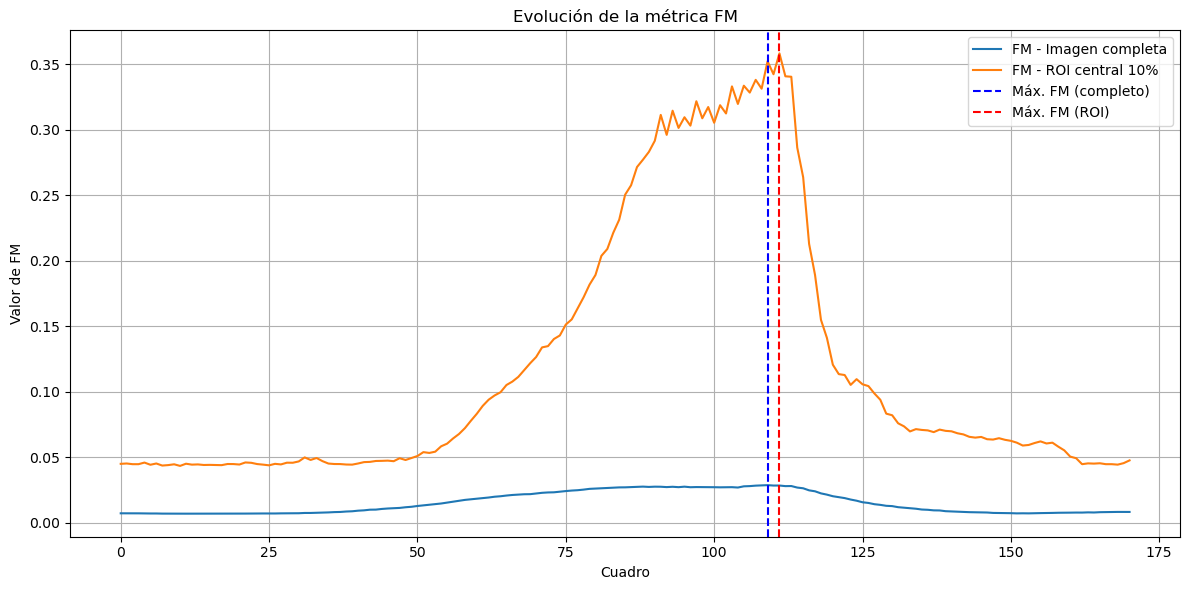

In [45]:
# ---- Gráfico ----

plt.figure(figsize=(12, 6))
plt.plot(indice_cuadro_list, fm_full_list, label="FM - Imagen completa")
plt.plot(indice_cuadro_list, fm_roi_list, label="FM - ROI central 10%")
plt.axvline(np.argmax(fm_full_list), color='blue', linestyle='--', label="Máx. FM (completo)")
plt.axvline(np.argmax(fm_roi_list), color='red', linestyle='--', label="Máx. FM (ROI)")
plt.xlabel("Cuadro")
plt.ylabel("Valor de FM")
plt.title("Evolución de la métrica FM")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [47]:
#DESARROLLO UTILIZANDO METRICA ACMo

In [49]:
def metrica_acmo(image: np.ndarray) -> float:
    
    """
    Calcula la métrica ACMo basada en el histograma de niveles de gris.
    """
    hist = cv2.calcHist([image], [0], None, [256], [0, 256])
    hist = hist / np.sum(hist)
    levels = np.arange(256)
    mu = np.sum(levels * hist.flatten())
    acmo = np.sum(np.abs(levels - mu) * hist.flatten())
    return acmo

In [51]:
def analisis_video_acmo(video_path: str, porcentaje_roi: float = 0.10):
    
    """
    Calcula ACMo para cada cuadro del video y grafica su evolución.
    """
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"No se pudo abrir el video: {video_path}")
        return

    acmo_full_list = []
    acmo_roi_list = []
    indice_cuadro_list = []

    frame_id = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        acmo_full = metrica_acmo(gray)
        roi = roi_central(gray, porcentaje_roi=porcentaje_roi)
        acmo_roi = metrica_acmo(roi)

        acmo_full_list.append(acmo_full)
        acmo_roi_list.append(acmo_roi)
        indice_cuadro_list.append(frame_id)

        frame_id += 1

    cap.release()
    
    # Graficar
    plt.figure(figsize=(12, 6))
    plt.plot(indice_cuadro_list, acmo_full_list, label="ACMo - Imagen completa", color='orange')
    plt.plot(indice_cuadro_list, acmo_roi_list, label=f"ACMo - ROI central {int(porcentaje_roi*100)}%", color='orangered')

    # Marcar máximos
    max_full = np.argmax(acmo_full_list)
    max_roi = np.argmax(acmo_roi_list)
    plt.axvline(x=max_full, color='blue', linestyle='--', label=f"Máx. ACMo (completo): frame {max_full}")
    plt.axvline(x=max_roi, color='red', linestyle='--', label=f"Máx. ACMo (ROI): frame {max_roi}")

    plt.xlabel("Índice de cuadro")
    plt.ylabel("Valor de ACMo")
    plt.title("Evolución de la métrica ACMo (Absolute Central Moment)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()    

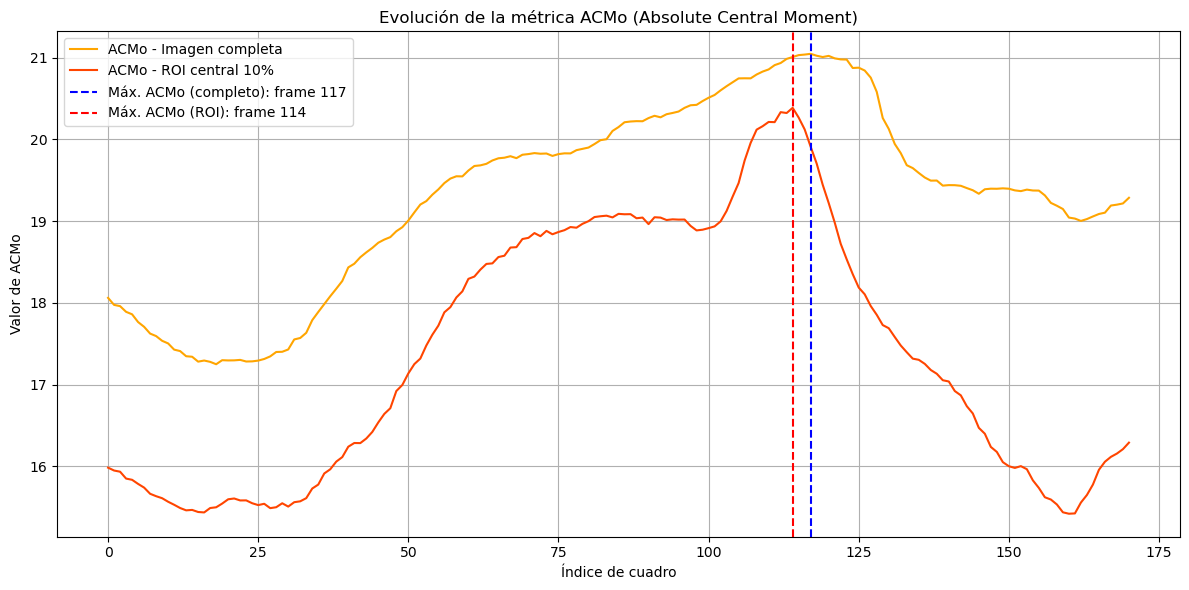

In [53]:
analisis_video_acmo(video_path, porcentaje_roi=0.10)

In [45]:
#CONCLUSIONES:

#- Con respecto a FM, los valores de la imagen completa son menores y más parejos que los valores de la imagen correspondiente a la ROI. 
#Se puede detectar de mejor manera la existencia de un único valor de enfoque, desfasado del valor de enfoque correspondiente a los valores de ROI. 
#Esto se debe a que cuando se considera toda la imagen no hay componentes de alta frecuencia como los que se pueden encontrar en el análisis aplicando 
#la ROI. 

In [47]:
#En el caso de los valores obtenidos con ACMo, hay una considerable variación de valores de los datos correspondientes a la computación de los valores 
#para cada valor de ROI, mientras que la evolución de valores computados de cada imagen es más pareja en la computación de la evolución de la métrica
#en cada cuadro para la imagen completa. Esto es inherente a la naturaleza de la métrica basada en la medición del histograma en vez de la frecuencia 
#como fue el caso de la FM. 